In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../Code/')
sys.path.append('../')
from testWN import testWN as twm

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from RNN_tools import get_model, keras2casadi
from surrogate_model_training_data import get_data

# Get network informations

In [3]:
inp_file = '../../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [4]:
cluster_labels = pd.read_json('cluster_labels.json')
pressure_factor = pd.read_json('pressure_factor.json')
n_clusters = 30

Get results:

In [5]:
file = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_30_try.pkl'
with open(file, 'rb') as f:
    results = pickle.load(f)

## Physical preprocessing:

### Junctions
Scale pressure for each node (similar to clustering)

In [6]:
junction_pressure_scaled = results.node['pressure'][node_names[2]]/pressure_factor.to_numpy()

In [7]:
jun_cl_press = junction_pressure_scaled.groupby(cluster_labels.loc['pressure'], axis=1)
jun_cl_press_mean = jun_cl_press.mean()
jun_cl_press_std = jun_cl_press.std()

jun_cl_demand = results.node['demand'][node_names[2]].groupby(cluster_labels.loc['pressure'], axis=1)
jun_cl_demand_sum = jun_cl_demand.sum()

jun_cl_qual = results.node['quality'][node_names[2]].diff(axis=0).groupby(cluster_labels.loc['quality'], axis=1)
qual_cl_qual_mean = jun_cl_qual.mean()
qual_cl_qual_std = jun_cl_qual.std()

<IPython.core.display.Javascript object>


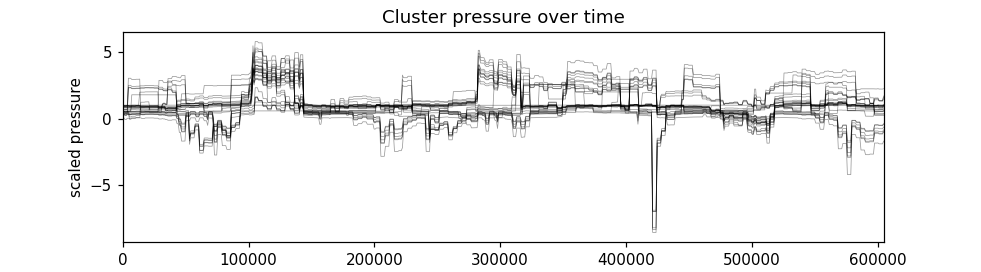

In [8]:
fig, ax = plt.subplots(figsize=(9,2.5))
jun_cl_press_mean.plot(ax=ax, legend=False, linewidth=0.5, color='k', alpha=0.4)
ax.set_xlabel('time [s]')
ax.set_ylabel('scaled pressure')
ax.set_title('Cluster pressure over time')
plt.show()

### Tanks

In [9]:
tank_press = results.node['pressure'][node_names[0]]
# Subtract tank elevation from tank head to obtain tank_level
tank_level = results.node['head'][node_names[0]]-nw_node_df[node_names[0]].loc['elevation']

tank_qual = results.node['quality'][node_names[0]]

<IPython.core.display.Javascript object>


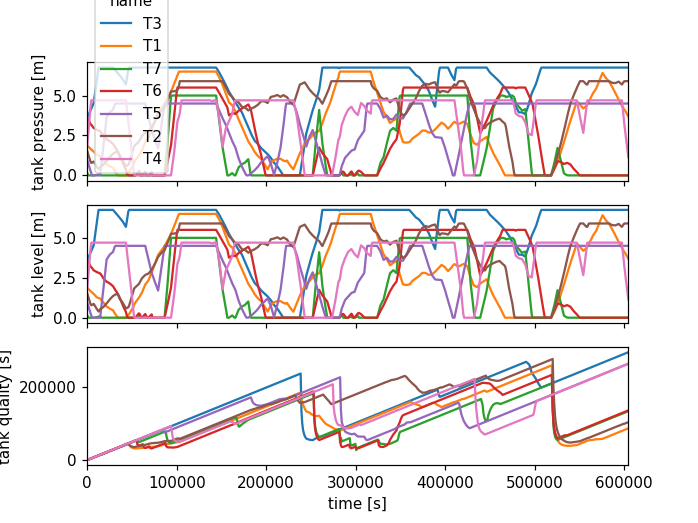

Text(0.5, 0, 'time [s]')

In [10]:
fig, ax = plt.subplots(3,1, sharex=True,)
tank_press.plot(ax=ax[0])
ax[0].set_ylabel('tank pressure [m]')
tank_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('tank level [m]')
tank_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('tank quality [s]')
ax[2].set_xlabel('time [s]')

### Reservoirs

In [11]:
reservoir_press = results.node['pressure'][node_names[1]]
reservoir_level = results.node['head'][node_names[1]]-nw_node_df[node_names[1]].loc['elevation']

reservoir_qual = results.node['quality'][node_names[1]]

<IPython.core.display.Javascript object>


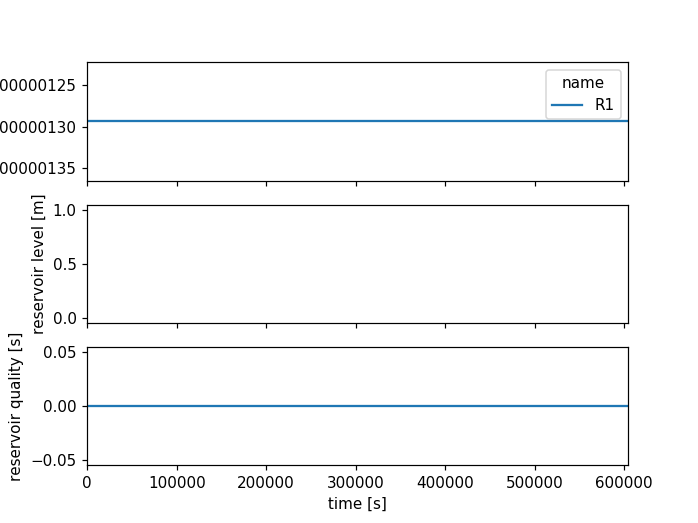

Text(0.5, 0, 'time [s]')

In [12]:
fig, ax = plt.subplots(3,1, sharex=True,)
reservoir_press.plot(ax=ax[0])
ax[0].set_ylabel('reservoir pressure [m]')
reservoir_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('reservoir level [m]')
reservoir_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('reservoir quality [s]')
ax[2].set_xlabel('time [s]')

### Pumps

In [13]:
head_pump_speed = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]

<IPython.core.display.Javascript object>


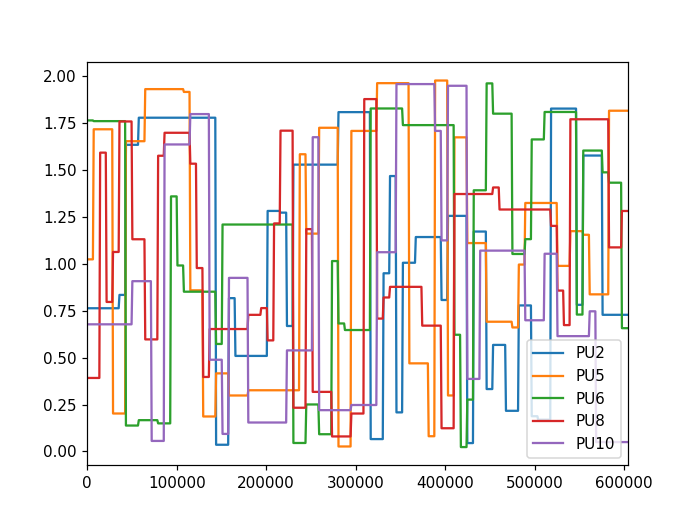

In [14]:
fig, ax = plt.subplots()
head_pump_speed.plot(ax=ax)

In [15]:
pump_energy = economics.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)[link_names[0]]
pump_energy /= 1000
pump_energy.head(3)

,PU2,PU5,PU6,PU8,PU10
0,29.017009,32.638078,256.344710,0.0,6.898073
900,28.996320,32.635053,256.898683,0.0,6.904056
1800,28.944180,32.631124,257.465625,0.0,6.885225


<IPython.core.display.Javascript object>


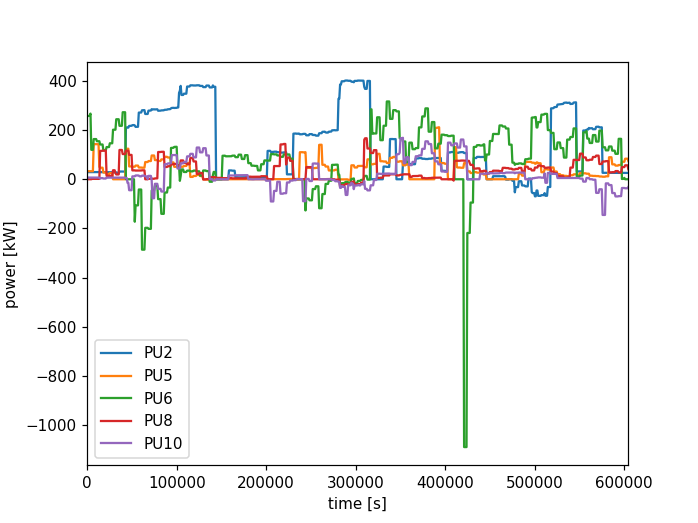

Text(0.5, 0, 'time [s]')

In [16]:
fig, ax = plt.subplots()
pump_energy.plot(ax=ax)
ax.set_ylabel('power [kW]')
ax.set_xlabel('time [s]')

### Valves

In [17]:
PRValve_dp = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

<IPython.core.display.Javascript object>


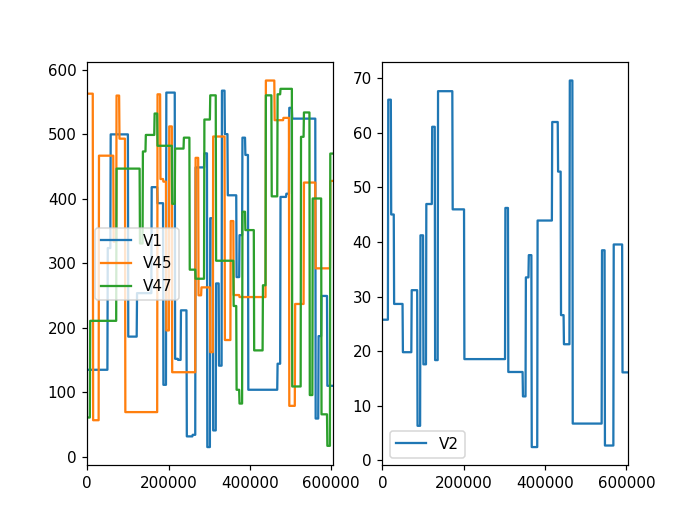

In [18]:
fig, ax = plt.subplots(1,2)
PRValve_dp.plot(ax=ax[0])
TCValve_throttle.plot(ax=ax[1])

## Neural Network Pre-Processing
### States and Inputs

In [19]:
state_dict = {'jun_cl_press_mean': jun_cl_press_mean,
              # 'jun_cl_press_std': jun_cl_press_std,
              # 'dqual_cl_press_mean': dqual_cl_press_mean,
              # 'dqual_cl_press_std': dqual_cl_press_std,
              'tank_press': tank_press,
              # 'tank_level': tank_level,
              # 'tank_qual': tank_qual,
              # 'reservoir_press': reservoir_press,
              # 'reservoir_level': reservoir_level,
              # 'reservoir_qual': reservoir_qual,
              }

sys_states = pd.concat(state_dict.values(), axis=1, keys=state_dict.keys())


input_dict = {'head_pump_speed': head_pump_speed,
              'PRValve_dp': PRValve_dp,
              'TCValve_throttle': TCValve_throttle,
              'jun_cl_demand_sum': jun_cl_demand_sum}

sys_inputs = pd.concat(input_dict.values(), axis=1, keys=input_dict.keys())

aux_output_dict = {'pump_energy': pump_energy,}

aux_outputs = pd.concat(aux_output_dict.values(), axis=1, keys=aux_output_dict.keys())

### Neural Network I/O

Outputs of the neural network.

Note: we are learning the next state of the system and the current aux_outputs (pump energy)

In [20]:
dsys_states = sys_states.diff(axis=0)

sys_states_next = sys_states.shift(-1, axis=0)
dsys_states_next = dsys_states.shift(-1, axis=0)

nn_output_dict = {'sys_states': sys_states_next,
                 #'dsys_states_next' : dsys_states_next,
                 'aux_outputs': aux_outputs}


nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

In [21]:
nn_output.head(3)

sys_states                                                    \
     jun_cl_press_mean                                                     
                     0         1         2         3         4         5   
0             0.660981  0.876917  0.506639  0.946038  0.809835  0.448989   
900           0.664182  0.875159  0.467084  0.943457  0.807115  0.374571   
1800          0.667397  0.874352  0.466474  0.942195  0.805867  0.373854   

                                              ...                       \
                                              ... tank_press             
             6         7         8         9  ...         T7        T6   
0     0.961763  0.331839  0.480088  0.545382  ...   0.011048  3.538649   
900   0.959441  0.336166  0.478197  0.545634  ...   0.000062  3.434553   
1800  0.958458  0.340493  0.476280  0.545924  ...   0.000062  3.326560   

                                  aux_outputs                              \
                                  pump_energy                               
            T5       T2        T4         PU2        PU5         PU6  PU8   
0     0.776806  1.35068  2.469473   29.017009  32.638078  256.344710  0.0   
900   0.608584  1.18436  3.071111   28.996320  32.635053  256.898683  0.0   
1800  0.440352  1.01924  3.671902   28.944180  32.631124  257.465625  0.0   

                
                
          PU10  
0     6.898073  
900   6.904056  
1800  6.885225  

[3 rows x 42 columns]

Inputs of the neural network:

In [22]:
nn_input_dict = {'sys_states': sys_states,
                 'sys_inputs': sys_inputs}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (673, 76)


In [23]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (672, 76)


In [24]:
print(nn_input.isnull().any().any())
print(nn_output.isnull().any().any())

False
False


### Normalize Data:

In [25]:
input_offset = nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

input_offset = input_offset.to_numpy().reshape(1,-1)
input_scaling = input_scaling.to_numpy().reshape(1,-1)
output_offset = output_offset.to_numpy().reshape(1,-1)
output_scaling = output_scaling.to_numpy().reshape(1,-1)

### Train/Test split:

In [26]:
tt_split = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2, shuffle=False)
X_train, X_test, Y_train, Y_test = [arr.to_numpy() for arr in tt_split]

## RNN I/O structure

In [27]:
seq_length = 20  # length of sequence for ANN training

# create sequences from the data:
X = []
Y = []

n_data = X_train.shape[0]
n_seq = n_data // seq_length - 1


for data_sample in range(n_seq):
    start_ind = data_sample*seq_length
    X.append(X_train[start_ind:start_ind + seq_length, :])
    Y.append(Y_train[start_ind:start_ind + seq_length, :])
    
X = np.stack(X, axis=0)  # [m, seq_length, nx]
Y = np.stack(Y, axis=0)  # [m, seq_length, ny]

In [87]:
X.shape

(25, 20, 76)

In [88]:
# If batch_size > 1 and stateful mode active, the order of the elements has to be adapted.
batch_size = 5
n_batches = X.shape[0]//batch_size
n_data_red = batch_size*n_batches
batch_ind = np.arange(n_data_red).reshape(-1, n_batches).T.ravel()

X = X[batch_ind, :, :]
Y = Y[batch_ind, :, :]

nx = X.shape[2]
ny = Y.shape[2]

In [89]:
X.shape

(25, 20, 76)

# Create RNN

In [29]:
stateful = True
n_layer = 2  # hidden layer - output layer (linear) is automatically added
model_param = {}
model_param['RNN_param'] = {}
model_param['n_units'] = (n_layer) * [40]
model_param['p_dropout'] = None  # Placeholder. Not yet used.
model_param['activation'] = (n_layer) * ['tanh']

model_param['RNN_param']['RNN_type'] = 'LSTM'
model_param['RNN_param']['n_activation'] = 40
model_param['RNN_param']['recurrent_dropout'] = 0
model_param['RNN_param']['dropout'] = 0.
model_param['RNN_param']['implementation'] = 2

model = get_model(model_param, nx, ny, batch_size=batch_size,
                  seq_length=seq_length, stateful=stateful)

model.summary()

No value selected for dropout, choosing do=0.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (5, 20, 40)               18720     
_________________________________________________________________
time_distributed (TimeDistri (5, 20, 40)               1640      
_________________________________________________________________
dropout (Dropout)            (5, 20, 40)               0         
_________________________________________________________________
time_distributed_1 (TimeDist (5, 20, 40)               1640      
_________________________________________________________________
dropout_1 (Dropout)          (5, 20, 40)               0         
_________________________________________________________________
time_distributed_2 (TimeDist (5, 20, 42)               1722      
Total params: 23,722
Trainable params: 23,722
Non-trainable params: 0
______

In [30]:
model.compile(loss='mse', optimizer='Adam')
if stateful:
    cb_reset = keras.callbacks.LambdaCallback(on_epoch_end=model.reset_states())
else:
    cb_reset = keras.callbacks.LambdaCallback()

model.fit(X, Y, callbacks=[cb_reset], batch_size=batch_size,
          epochs=300, verbose=1, shuffle=not(stateful))

Train on 25 samples
Epoch 1/300
25/25 [==============================] - 4s 147ms/sample - loss: 0.1652
Epoch 2/300
25/25 [==============================] - 0s 4ms/sample - loss: 0.1323
Epoch 3/300
25/25 [==============================] - 0s 10ms/sample - loss: 0.1130
Epoch 4/300
25/25 [==============================] - 0s 5ms/sample - loss: 0.0980
Epoch 5/300
25/25 [==============================] - 0s 7ms/sample - loss: 0.0850
Epoch 6/300
25/25 [==============================] - 0s 7ms/sample - loss: 0.0736
Epoch 7/300
25/25 [==============================] - 0s 5ms/sample - loss: 0.0638
Epoch 8/300
25/25 [==============================] - 0s 4ms/sample - loss: 0.0559
Epoch 9/300
25/25 [==============================] - 0s 8ms/sample - loss: 0.0496
Epoch 10/300
25/25 [==============================] - 0s 4ms/sample - loss: 0.0447
Epoch 11/300
25/25 [==============================] - 0s 5ms/sample - loss: 0.0409
Epoch 12/300
25/25 [==============================] - 0s 5ms/sample - los

25/25 [==============================] - 0s 5ms/sample - loss: 0.0063
Epoch 100/300
25/25 [==============================] - 0s 4ms/sample - loss: 0.0062
Epoch 101/300
25/25 [==============================] - 0s 3ms/sample - loss: 0.0063
Epoch 102/300
25/25 [==============================] - 0s 3ms/sample - loss: 0.0065
Epoch 103/300
25/25 [==============================] - 0s 3ms/sample - loss: 0.0074
Epoch 104/300
25/25 [==============================] - 0s 3ms/sample - loss: 0.0082
Epoch 105/300
25/25 [==============================] - 0s 3ms/sample - loss: 0.0072
Epoch 106/300
25/25 [==============================] - 0s 4ms/sample - loss: 0.0068
Epoch 107/300
25/25 [==============================] - 0s 4ms/sample - loss: 0.0068
Epoch 108/300
25/25 [==============================] - 0s 4ms/sample - loss: 0.0061
Epoch 109/300
25/25 [==============================] - 0s 3ms/sample - loss: 0.0060
Epoch 110/300
25/25 [==============================] - 0s 3ms/sample - loss: 0.0060
Epoch 

25/25 [==============================] - 0s 4ms/sample - loss: 0.0038
Epoch 197/300
25/25 [==============================] - 0s 3ms/sample - loss: 0.0039
Epoch 198/300
25/25 [==============================] - 0s 4ms/sample - loss: 0.0039
Epoch 199/300
25/25 [==============================] - 0s 5ms/sample - loss: 0.0040
Epoch 200/300
25/25 [==============================] - 0s 10ms/sample - loss: 0.0043
Epoch 201/300
25/25 [==============================] - 0s 5ms/sample - loss: 0.0045
Epoch 202/300
25/25 [==============================] - 0s 7ms/sample - loss: 0.0047
Epoch 203/300
25/25 [==============================] - 0s 4ms/sample - loss: 0.0046
Epoch 204/300
25/25 [==============================] - 0s 3ms/sample - loss: 0.0045
Epoch 205/300
25/25 [==============================] - 0s 5ms/sample - loss: 0.0044
Epoch 206/300
25/25 [==============================] - 0s 3ms/sample - loss: 0.0043
Epoch 207/300
25/25 [==============================] - 0s 6ms/sample - loss: 0.0040
Epoch

25/25 [==============================] - 0s 5ms/sample - loss: 0.0030
Epoch 294/300
25/25 [==============================] - 0s 6ms/sample - loss: 0.0030
Epoch 295/300
25/25 [==============================] - 0s 6ms/sample - loss: 0.0030
Epoch 296/300
25/25 [==============================] - 0s 5ms/sample - loss: 0.0031
Epoch 297/300
25/25 [==============================] - 0s 5ms/sample - loss: 0.0031
Epoch 298/300
25/25 [==============================] - 0s 6ms/sample - loss: 0.0032
Epoch 299/300
25/25 [==============================] - 0s 6ms/sample - loss: 0.0033
Epoch 300/300
25/25 [==============================] - 0s 7ms/sample - loss: 0.0034


# Evaluate Model

In [31]:
model_simple = get_model(model_param, nx, ny, batch_size=1,
                         seq_length=1, stateful=stateful)

model_simple.set_weights(model.get_weights())

model_simple.summary()
model_simple.reset_states()

No value selected for dropout, choosing do=0.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 1, 40)                18720     
_________________________________________________________________
time_distributed_3 (TimeDist (1, 1, 40)                1640      
_________________________________________________________________
dropout_2 (Dropout)          (1, 1, 40)                0         
_________________________________________________________________
time_distributed_4 (TimeDist (1, 1, 40)                1640      
_________________________________________________________________
dropout_3 (Dropout)          (1, 1, 40)                0         
_________________________________________________________________
time_distributed_5 (TimeDist (1, 1, 42)                1722      
Total params: 23,722
Trainable params: 23,722
Non-trainable params: 0
____

Initialize hidden state:

In [32]:
model_simple.reset_states()
# Initialize hidden state:
t = 0
dt = 900
for x_i in X_train[:seq_length,:]:
    x_i = x_i.reshape(1, 1, -1)
    y_i = model_simple.predict(x_i)
    t += dt

In [33]:
x_arr = [sys_states.iloc[seq_length].to_numpy().reshape(1,-1)]
t_arr = [t]
for i,u_i in sys_inputs.iloc[seq_length:].iterrows():
    rnn_in_i = np.concatenate((x_arr[-1],u_i.to_numpy().reshape(1,-1)),axis=1)
    rnn_in_scaled = (rnn_in_i - input_offset)/input_scaling
    rnn_out_scaled = model_simple.predict(rnn_in_scaled.reshape(1,1,-1))
    rnn_out = rnn_out_scaled.squeeze()*output_scaling+output_offset
    t_arr.append(t_arr[-1]+dt)
    x_arr.append(rnn_out[[0],:37])
    
res = np.concatenate(x_arr)

In [34]:
res = pd.DataFrame(res, columns=sys_states.columns, index=t_arr)

In [35]:
res.head(3)

jun_cl_press_mean                                                    \
                      0         1         2         3         4         5   
18000          2.300231  0.867587  0.504891  0.961925  0.794975  0.446042   
18900          2.151105  0.846401  0.499310  0.914141  0.831739  0.524888   
19800          2.128530  0.846074  0.534401  0.892256  0.826722  0.564855   

                                               ...                      \
              6         7         8         9  ...        27        28   
18000  0.941508  2.484007  0.871719  2.000097  ...  0.529784  0.907765   
18900  0.930408  2.228852  0.930206  2.038620  ...  0.589398  0.869542   
19800  0.921439  2.154528  0.855358  2.067082  ...  0.621696  0.884149   

                tank_press                                                    \
             29         T3        T1        T7        T6        T5        T2   
18000  0.546132   6.749999  0.941941  0.000025  2.464622  1.770095  0.667699   
18900  0.588271   6.880101  0.913591 -0.126973  2.360932  2.325608  0.838243   
19800  0.592189   6.916536  0.883512 -0.122158  2.258904  2.781233  0.975070   

                 
             T4  
18000  4.699997  
18900  4.660605  
19800  4.640381  

[3 rows x 37 columns]

<IPython.core.display.Javascript object>


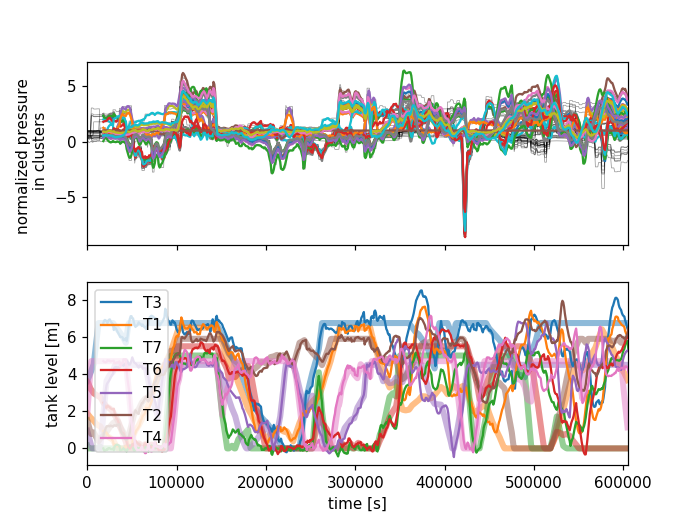

Text(0.5, 0, 'time [s]')

In [36]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
res['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
res['tank_press'].plot(ax=ax[1])

ax[0].set_xlim(0, res.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

# Keras 2 Casadi

In [39]:
from casadi import *

In [58]:
config = model_simple.get_config()
weights = model_simple.get_weights()

In [61]:
x_cas_in = MX.sym('x', 1, 76)
h_cas_in = MX.sym('h', 1, 40)
c_cas_in = MX.sym('c', 1, 40)

[x_cas_out, h_cas_out, c_cas_out], _ = keras2casadi(
    weights, config['layers'], [x_cas_in, h_cas_in, c_cas_in], backend_name='casadi')
fun = Function('fun', [x_cas_in, h_cas_in, c_cas_in], [x_cas_out, h_cas_out, c_cas_out])

In [84]:
x = np.ones((1, 76))
h = np.zeros((1, 40))
c = np.zeros((1, 40))

In [80]:
x = np.ones((1, 76))
x,h,c = fun(x,h,c)

In [81]:
x.full()

array([[ 0.373,  0.226,  0.37 ,  0.241,  0.196,  0.287,  0.187,  0.409,  0.645,  0.175,  0.205,  0.233,  0.417,  0.383,  0.798,  0.212,  0.273,  0.138,  0.154,  0.418,  0.298,  0.571,  0.215,  0.406,  0.177,  0.04 ,  0.184,  0.208,  0.207,  0.199, -0.18 ,  0.285, -0.061,  0.45 ,  0.316,  0.426,
         0.59 ,  0.218,  0.481,  0.312, -0.3  ,  0.324]])

In [77]:
model_simple.reset_states()

In [82]:
x = np.ones((1, 76))
model_simple.predict(x.reshape(1,1,-1))

array([[[ 0.373,  0.226,  0.37 ,  0.241,  0.196,  0.287,  0.187,  0.409,  0.645,  0.175,  0.205,  0.233,  0.417,  0.383,  0.798,  0.212,  0.273,  0.138,  0.154,  0.418,  0.298,  0.571,  0.215,  0.406,  0.177,  0.04 ,  0.184,  0.208,  0.207,  0.199, -0.18 ,  0.285, -0.061,  0.45 ,  0.316,  0.426,
          0.59 ,  0.218,  0.481,  0.312, -0.3  ,  0.324]]], dtype=float32)

# Create Full Training Dataset
Load data (lists of pandas objects)

In [12]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/'
file_list = os.listdir(data_path)[:10]
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
nn_input_list, nn_output_list = get_data(file_list, 0, narx_input=False, narx_output=False, return_lists=True)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "/home/ffiedler/Documents/git_repos/2019_WNTR_Surrogate_Model/Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



Convert to list of numpy arrays:

In [35]:
nn_input_np_list = [i.to_numpy() for i in nn_input_list]
nn_output_np_list = [i.to_numpy() for i in nn_output_list]

Concatenate in time dimension:

In [40]:
nn_input_concat = np.concatenate(nn_input_np_list,axis =0)
nn_output_concat = np.concatenate(nn_output_np_list,axis =0)

Normalize data:

1.) Get factors:

In [47]:
input_offset = nn_input_concat.mean(axis=0, keepdims=True)
nn_input_offset = nn_input_concat - input_offset
input_scaling = np.max(np.abs(nn_input_offset),axis=0, keepdims=True)
input_scaling = np.maximum(input_scaling, 1e-5)

output_offset = nn_output_concat.mean(axis=0, keepdims=True)
nn_output_offset = nn_output_concat - output_offset
output_scaling = np.max(np.abs(nn_output_offset),axis=0, keepdims=True)
output_scaling =  np.maximum(output_scaling, 1e-5)

2.) Apply to list:

In [53]:
nn_input_np_list_norm = [(i-input_offset)/input_scaling for i in nn_input_np_list]
nn_output_np_list_norm = [(i-output_offset)/output_scaling for i in nn_output_np_list]

Stack lists:

In [54]:
nn_input_stacked = np.stack(nn_input_np_list_norm, axis=0)
nn_output_stacked = np.stack(nn_output_np_list_norm, axis=0)

In [55]:
seq_length = 30  # length of sequence for ANN training

# create sequences from the data:
X = []
Y = []

n_data = nn_output_np.shape[1]
n_seq = n_data // seq_length - 1


for data_sample in range(n_seq):
    start_ind = data_sample*seq_length
    X.append(nn_input_stacked[:,start_ind:start_ind + seq_length, :])
    Y.append(nn_output_stacked[:,start_ind:start_ind + seq_length, :])
    
X = np.concatenate(X, axis=0)  # [m, seq_length, nx]
Y = np.concatenate(Y, axis=0)  # [m, seq_length, ny]

In [56]:
X.shape

(210, 30, 76)